In [1]:
#ruff: noqa: T201, T203
from __future__ import annotations

import os
from pathlib import Path

if Path.cwd().name == 'notebooks':
    os.chdir('..')

In [2]:
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed
from pprint import pprint
from typing import Callable

import numpy as np
import pandas as pd
from dotenv import load_dotenv
from tqdm import tqdm

from src.constants import PAIRS_SEPARATOR, BinaryOutputFormat, LLMCallOutput
from src.evaluate import (
    analyze_results,
    extend_preds_with_labels_info,
    get_gt_pairs,
    get_pred_pairs,
    plot_usage_histograms,
)
from src.LLM_servers.openai import OpenAIServer
from src.onto_access import OntologyAccess
from src.onto_object import OntologyEntryAttr
from src.prompts.system import BASELINE_INITIALIZATION_MESSAGE
from src.utils import (
    calculate_logpropgs_confidence,
    read_file,
    write_lines,
)

logging.getLogger().setLevel(logging.WARNING)
load_dotenv()

%load_ext autoreload
%autoreload 2

In [3]:
DATA_DIR = Path('./data')
OUTPUTS_DIR = Path("./outputs")
METRICS_DIR = Path("./metrics")

## Prompts

In [4]:
def prompt_with_hierarchy(src_entety: OntologyEntryAttr, tgt_entety: OntologyEntryAttr) -> str:
    return f"""
    Given two entities from different ontologies with their names, parent relationships, and child relationships, determine if these concepts are the same:

    1. Source Entity:
    All Entity names: {src_entety.get_all_entity_names()}
    Parent Entity Namings: {src_entety.get_parents_preferred_names()}
    Child Entity Namings: {src_entety.get_children_preferred_names()}

    2. Target Entity:
    All Entity names: {tgt_entety.get_all_entity_names()}
    Parent Entity Namings: {tgt_entety.get_parents_preferred_names()}
    Child Entity Namings: {tgt_entety.get_children_preferred_names()}

    Response with True or False
    """  # noqa: E501


def prompt_only_with_parents(src_entety: OntologyEntryAttr, tgt_entety: OntologyEntryAttr) -> str:
    return f"""
    Given two entities from different ontologies with their names and parent relationships, determine if these concepts are the same:

    1. Source Entity:
    All Entity names: {src_entety.get_all_entity_names()}
    Parent Entity Namings: {src_entety.get_parents_preferred_names()}

    2. Target Entity:
    All Entity names: {tgt_entety.get_all_entity_names()}
    Parent Entity Namings: {tgt_entety.get_parents_preferred_names()}

    Response with True or False
    """  # noqa: E501


def prompt_only_names(src_entety: OntologyEntryAttr, tgt_entety: OntologyEntryAttr) -> str:
    return f"""
    Given two entities from different ontologies with their names, determine if these concepts are the same:

    1. Source Entity:
    All Entity names: {src_entety.get_all_entity_names()}

    2. Target Entity:
    All Entity names: {tgt_entety.get_all_entity_names()}

    Response with True or False
    """


def prompt_only_with_children(src_entety: OntologyEntryAttr, tgt_entety: OntologyEntryAttr) -> str:
    return f"""
    Given two entities from different ontologies with their names and child relationships, determine if these concepts are the same:

    1. Source Entity:
    All Entity names: {src_entety.get_all_entity_names()}
    Child Entity Namings: {src_entety.get_children_preferred_names()}

    2. Target Entity:
    All Entity names: {tgt_entety.get_all_entity_names()}
    Child Entity Namings: {tgt_entety.get_children_preferred_names()}

    Response with True or False
    """  # noqa: E501


def prompt_synonyms_subsumption(source_entry: OntologyEntryAttr, target_entry: OntologyEntryAttr) -> str:
    """Create a prompt to determine if one entity's synonyms suggest it subsumes the other."""
    return f"""
    **Task Description:**
    Given two entities with their synonyms, determine if one entity subsumes the other.

    1. **Source Entity Synonyms:** {source_entry.get_synonyms()}
    2. **Target Entity Synonyms:** {target_entry.get_synonyms()}

    Response with True or False
    """


def prompt_one_name_one_synonym(source_entry: OntologyEntryAttr, target_entry: OntologyEntryAttr) -> str:
    """Create a prompt to determine if one entity's synonyms suggest it subsumes the other."""
    return f"""
    **Task Description:**
    Given two entities with their synonyms, determine if one entity subsumes the other.

    1. **Source Entity Synonyms:** {max(list(source_entry.get_synonyms()), key=len)}
    2. **Target Entity Names:** {max(list(target_entry.get_all_entity_names()), key=len)}

    Response with True or False
    """


## Inference pipeline

In [5]:
def format_oracle_predictions_filepath(set_name: str, model: str, exp_name: str) -> Path:
    return OUTPUTS_DIR / "llm_oracle_results" / f"{set_name}_{model}_{exp_name}.txt"


def format_confusion_matrix_filepath(set_name: str, model: str, exp_name: str, suffix: str = "") -> Path:
    if suffix:
        return METRICS_DIR / "confusion_matrices" / f"{set_name}_{model}_{exp_name}_{suffix}.png"
    return METRICS_DIR / "confusion_matrices" / f"{set_name}_{model}_{exp_name}.png"


def format_gt_pairs_filepath(dataset_path: str, set_name: str) -> Path:
    return DATA_DIR / dataset_path / set_name / "refs_equiv/full.tsv"


def format_oracle_pairs_filepath(dataset_name: str, set_name: str) -> Path:
    return DATA_DIR / dataset_name / set_name / f"{dataset_name}-{set_name}-logmap_mappings_to_ask_oracle_user_llm.txt"


def get_predictions_with_gt(
    dataset_name: str, set_name: str, model: str, exp_name: str
) -> tuple[pd.DataFrame, pd.DataFrame]:
    gt_positive_pairs_path = format_gt_pairs_filepath(dataset_name, set_name)
    pred_results_path = format_oracle_predictions_filepath(set_name, model, exp_name)
    gt_df = get_gt_pairs(gt_positive_pairs_path)
    pred_df = get_pred_pairs(pred_results_path)
    return extend_preds_with_labels_info(pred_df, gt_df)


In [6]:
def extract_llm_compeletion_answer(response: LLMCallOutput) -> bool:
    """Extract the completion answer from the LLM response."""
    if isinstance(response.parsed, BinaryOutputFormat):
        return response.parsed.answer
    raise NotImplementedError()

def process_sample(
    candidate_pairs_line: str,
    llm_oracle: OpenAIServer,
    onto_src: OntologyAccess,
    onto_tgt: OntologyAccess,
    model: str,
    prompt_function: Callable,
    one_more_time: bool = True,
) -> tuple[str, tuple[int, int], float]:
    """Process a single line: generate a prompt, send it to the LLM, and extract the response."""
    try:
        source = candidate_pairs_line.split(PAIRS_SEPARATOR)[0]
        target = candidate_pairs_line.split(PAIRS_SEPARATOR)[1]

        try:
            prompt = prompt_function(OntologyEntryAttr(source, onto_src), OntologyEntryAttr(target, onto_tgt))
        except AssertionError:
            prompt = prompt_function(OntologyEntryAttr(target, onto_src), OntologyEntryAttr(source, onto_tgt))

        response: LLMCallOutput = llm_oracle.ask_sync_question(prompt, model)
        answer = extract_llm_compeletion_answer(response)

        input_tokens = response.usage.input_tokens
        output_tokens = response.usage.output_tokens
        confidence = calculate_logpropgs_confidence(response.logprobs)

        token_usage = (input_tokens, output_tokens)
        result = f"{source}|{target}|{answer}|{confidence}"
        return result, token_usage, confidence

    except Exception:  # noqa: BLE001
        if one_more_time:
            return process_sample(
                candidate_pairs_line, llm_oracle, onto_src, onto_tgt, model, prompt_function, one_more_time=False
            )
        return f"{source}|{target}|ERROR|{np.nan}", (np.nan, np.nan), np.nan


def parallel_samples_process(
    candidate_pairs_lines: list[str],
    llm_oracle: OpenAIServer,
    onto_src: OntologyAccess,
    onto_tgt: OntologyAccess,
    model: str,
    max_workers: int,
    prompt_function: Callable,
) -> tuple[list[str], list[tuple[int, int]], list[float]]:
    """Process lines in parallel, with progress tracking using tqdm."""
    results = []
    tokens_usage = []
    confidences = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_line = {
            executor.submit(process_sample, line, llm_oracle, onto_src, onto_tgt, model, prompt_function): line
            for line in candidate_pairs_lines
        }

        for future in tqdm(
            as_completed(future_to_line), total=len(future_to_line), desc=f"Processing Lines {prompt_function.__name__}"
        ):
            result, token_usage, confidence = future.result()
            results.append(result)
            tokens_usage.append(token_usage)
            confidences.append(confidence)

    return results, tokens_usage, confidences


In [ ]:
llm_oracle = OpenAIServer()
llm_oracle.add_system_context(BASELINE_INITIALIZATION_MESSAGE)

In [8]:
DATASET_NAME = "anatomy"
SET_NAME = "human-mouse"
SOURCE_ONTOLOGY = "mouse"
TARGET_ONTOLOGY = "human"

src_onto_path = DATA_DIR / DATASET_NAME / SET_NAME / f"{SOURCE_ONTOLOGY}.owl"
tgt_onto_path = DATA_DIR / DATASET_NAME / SET_NAME / f"{TARGET_ONTOLOGY}.owl"

onto_src = OntologyAccess(src_onto_path, annotate_on_init=True)
onto_tgt = OntologyAccess(tgt_onto_path, annotate_on_init=True)

* Owlready2 * Creating new ontology human <data/anatomy/human-mouse/human.owl#>.
* Owlready2 * ADD TRIPLE data/anatomy/human-mouse/human.owl http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#Ontology
* Owlready2 *     ...loading ontology human from data/anatomy/human-mouse/human.owl...


* Owlready2 * Reseting property oboInOwl.ObsoleteProperty: new triples are now available.
* Owlready2 * Reseting property oboInOwl.hasRelatedSynonym: new triples are now available.
* Owlready2 * Reseting property oboInOwl.hasDefaultNamespace: new triples are now available.
* Owlready2 * Reseting property oboInOwl.savedBy: new triples are now available.
* Owlready2 * Reseting property oboInOwl.hasDate: new triples are now available.


* Owlready2 *     ...8 properties found: ObsoleteProperty, UNDEFINED_part_of, label, hasRelatedSynonym, hasDefaultNamespace, savedBy, hasDate, hasDefinition


In [35]:
# access the ontology entry example
entry_uri = "http://human.owl#NCI_C33075"
entry = OntologyEntryAttr(entry_uri, onto_tgt)

print(entry)
print(entry.get_all_entity_names())
print(entry.get_parents_preferred_names())
print(entry.get_children_preferred_names())
print(entry.get_synonyms())
print(entry.get_direct_parents())
print(entry.get_direct_parents().pop().get_direct_children())

repr(entry.get_parents_byhierarchy_with_hierarchy_levels(max_level=8))

all_parents_by_levels = entry.get_parents_byhierarchy_with_hierarchy_levels(max_level=8)
[(i, x.get_preffered_names()) for i, by_levels in all_parents_by_levels.items()  for x in by_levels]

{'class': human.NCI_C33075, 'uri': 'http://human.owl#NCI_C33075', 'preffered_names': {'Meibomian_Gland'}, 'synonyms': {'Meibomian Gland'}, 'all_names': {'Meibomian Gland', 'Meibomian_Gland'}, 'parents': {owl.Thing, human.NCI_C33519, human.NCI_C13018, human.NCI_C12712, human.NCI_C12219, human.NCI_C13319}, 'children': set()}
{'Meibomian Gland', 'Meibomian_Gland'}
[{'Thing'}, {'Sebaceous_Gland'}, {'Organ'}, {'Exocrine_Gland'}, {'Anatomic_Structure_System_or_Substance'}, {'Gland'}]
[]
{'Meibomian Gland'}
{human.NCI_C33519}
{human.NCI_C33521, human.NCI_C33075}


[(0, {'Meibomian_Gland'}),
 (1, {'Sebaceous_Gland'}),
 (2, {'Exocrine_Gland'}),
 (3, {'Gland'}),
 (4, {'Organ'}),
 (5, {'Anatomic_Structure_System_or_Substance'}),
 (6, {'Thing'})]

In [ ]:
# access the ontology entry example
entry_uri = "http://human.owl#NCI_C33075"
entry = OntologyEntryAttr(entry_uri, onto_tgt)

print(entry)
print(entry.get_all_entity_names())
print(entry.get_parents_preferred_names())
print(entry.get_children_preferred_names())
print(entry.get_synonyms())
print(entry.get_direct_parents())
print(entry.get_direct_parents().pop().get_direct_children())

repr(entry.get_parents_by_levels(max_level=8))

all_parents_by_levels = entry.get_parents_by_levels(max_level=8)
[(level, x.get_preffered_names()) for level, by_levels in all_parents_by_levels.items()  for x in by_levels]

{'class': human.NCI_C33075, 'uri': 'http://human.owl#NCI_C33075', 'preffered_names': {'Meibomian_Gland'}, 'synonyms': {'Meibomian Gland'}, 'all_names': {'Meibomian Gland', 'Meibomian_Gland'}, 'parents': {owl.Thing, human.NCI_C33519, human.NCI_C13018, human.NCI_C12712, human.NCI_C12219, human.NCI_C13319}, 'children': set()}
{'Meibomian Gland', 'Meibomian_Gland'}
[{'Thing'}, {'Sebaceous_Gland'}, {'Organ'}, {'Exocrine_Gland'}, {'Anatomic_Structure_System_or_Substance'}, {'Gland'}]
[]
{'Meibomian Gland'}
{human.NCI_C33519}
{human.NCI_C33521, human.NCI_C33075}


[(0, {'Meibomian_Gland'}),
 (1, {'Sebaceous_Gland'}),
 (2, {'Exocrine_Gland'}),
 (3, {'Gland'}),
 (4, {'Organ'}),
 (5, {'Anatomic_Structure_System_or_Substance'}),
 (6, {'Thing'})]

In [78]:
some_entry = next(iter(all_parents_by_levels[2]))
print(some_entry)
pprint(
    {
        level: [x.get_preffered_names() for x in relatives]
        for level, relatives in some_entry.get_children_by_levels(max_level=4).items()
    }
)

{'class': human.NCI_C12712, 'uri': 'http://human.owl#NCI_C12712', 'preffered_names': {'Exocrine_Gland'}, 'synonyms': {'Exocrine Gland', 'A gland from which secretions reach a free surface of the body by ducts.'}, 'all_names': {'A gland from which secretions reach a free surface of the body by ducts.', 'Exocrine Gland', 'Exocrine_Gland'}, 'parents': {human.NCI_C12219, human.NCI_C13319, human.NCI_C13018, owl.Thing}, 'children': {human.NCI_C12367, human.NCI_C32536, human.NCI_C32643, human.NCI_C12426, human.NCI_C33539, human.NCI_C33141, human.NCI_C32261, human.NCI_C32296, human.NCI_C32987, human.NCI_C13010, human.NCI_C33431, human.NCI_C32294, human.NCI_C12339, human.NCI_C12234, human.NCI_C33129, human.NCI_C49311, human.NCI_C33249, human.NCI_C32132, human.NCI_C32904, human.NCI_C33519, human.NCI_C32395, human.NCI_C12675, human.NCI_C12999, human.NCI_C33537, human.NCI_C12427, human.NCI_C12410, human.NCI_C12346, human.NCI_C32237, human.NCI_C12233, human.NCI_C32679, human.NCI_C33521, human.NCI_C

Processing Lines prompt_only_names: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Mean input tockens: 157.6
Mean output tockens: 6.0
Total input tockens: 1576
Total output tockens: 60


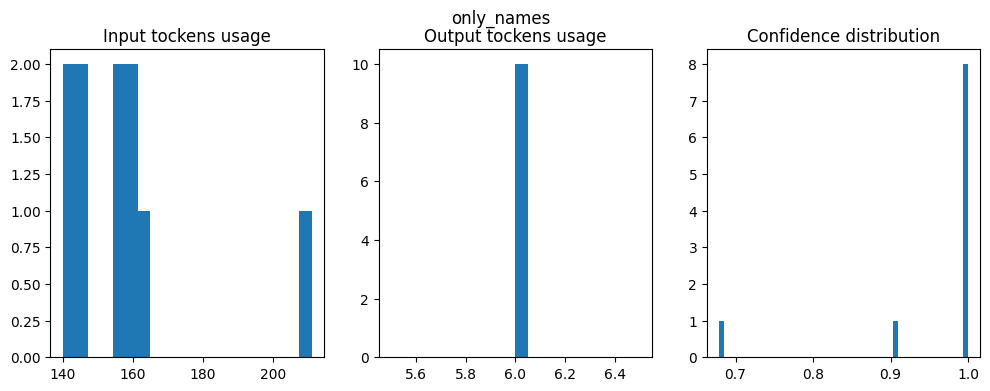

Accuracy: 0.70
Precision: 0.78
Recall: 0.88
F1 Score: 0.82


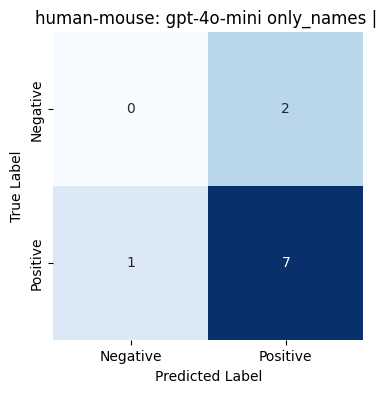

In [ ]:
MAX_WORKERS = 6
MODEL = "gpt-4o-mini"

EXP_NAMES_TO_PROMPT_FUNCTIONS = {
    "only_names": prompt_only_names,
    "with_hierarchy": prompt_with_hierarchy,
    "only_with_parents": prompt_only_with_parents,
    "only_with_children": prompt_only_with_children,
    "synonyms_subsumption": prompt_synonyms_subsumption,
    "one_name_one_synonym": prompt_one_name_one_synonym,
}


candidates_save_path = format_oracle_pairs_filepath(DATASET_NAME, SET_NAME)
candidate_pairs_lines = read_file(candidates_save_path)[:10]

for current_exp_name, prompt_function in EXP_NAMES_TO_PROMPT_FUNCTIONS.items():

    results, tokens_usage, confidences = parallel_samples_process(
        candidate_pairs_lines, llm_oracle, onto_src, onto_tgt, MODEL, MAX_WORKERS, prompt_function
    )
    plot_usage_histograms(tokens_usage, confidences, do_plot=True, do_print=True, suptitle=current_exp_name)

    prediction_path = format_oracle_predictions_filepath(SET_NAME, MODEL, current_exp_name)
    write_lines(results, prediction_path)

    predictions = get_predictions_with_gt(DATASET_NAME, SET_NAME, MODEL, current_exp_name)

    confusion_matrix_save_path = format_confusion_matrix_filepath(SET_NAME, MODEL, current_exp_name, suffix='dev')
    analyze_results(
        predictions,
        print_results=True,
        plot_confusion_matrix=True,
        subtitle=f"{SET_NAME}: {MODEL} {current_exp_name} | ",
        cm_save_path=confusion_matrix_save_path,
    )
    print("\n\n\n")
    break


## Metrics analysis

Accuracy: 0.70
Precision: 0.78
Recall: 0.88
F1 Score: 0.82


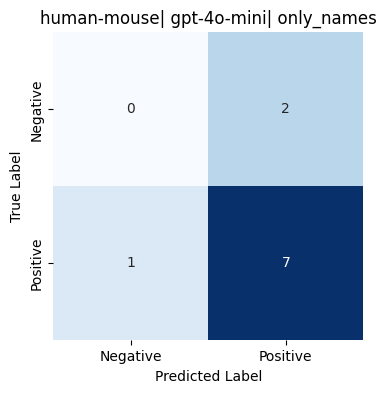

In [31]:
exp_name = "only_names"
predictions = get_predictions_with_gt(DATASET_NAME, SET_NAME, MODEL, exp_name)
analyze_results(
    predictions, print_results=True, plot_confusion_matrix=True, subtitle=f"{SET_NAME}| {MODEL}| {exp_name}"
);

## analyze false predictions

In [32]:
def print_results_entry(res_df:pd.DataFrame, pair_type:str="FP", idx:int=0) -> None:
    source_uri = res_df[res_df["Type"] == pair_type].iloc[idx]["Source"]
    target_uri = res_df[res_df["Type"] == pair_type].iloc[idx]["Target"]

    try:
        source_entry = OntologyEntryAttr(source_uri, onto_src)
        target_entry = OntologyEntryAttr(target_uri, onto_tgt)
    except Exception:
        source_entry = OntologyEntryAttr(source_uri, onto_tgt)
        target_entry = OntologyEntryAttr(target_uri, onto_src)

    print(f"Processing pair {idx} of type {pair_type}")
    pprint("Source Entry:\n")
    pprint(source_entry.annotation)
    pprint("Target Entry:\n")
    pprint(target_entry.annotation)

    print(f"Parent of Source Concept: {source_entry.get_parents_preferred_names()}")
    print(f"Parent of Target Concept: {target_entry.get_parents_preferred_names()}")

In [33]:
exp_name = "only_names"
res_df = get_predictions_with_gt(DATASET_NAME, SET_NAME, model='gpt-4o-mini', exp_name=exp_name)

In [14]:
res_df

,Source,Target,Prediction,Confidence,Label,Type
0,http://human.owl#NCI_C33075,http://mouse.owl#MA_0001249,True,0.999998,True,TP
1,http://human.owl#NCI_C53050,http://mouse.owl#MA_0002234,True,0.999999,False,FP
2,http://human.owl#NCI_C33748,http://mouse.owl#MA_0001221,True,0.999999,True,TP
3,http://human.owl#NCI_C32658,http://mouse.owl#MA_0002684,False,0.993307,True,FN
4,http://human.owl#NCI_C33743,http://mouse.owl#MA_0002390,False,0.998073,True,FN
5,http://human.owl#NCI_C12262,http://mouse.owl#MA_0001615,True,0.999998,True,TP
6,http://human.owl#NCI_C32497,http://mouse.owl#MA_0000451,True,0.999998,True,TP
7,http://human.owl#NCI_C33627,http://mouse.owl#MA_0001460,True,0.970686,False,FP
8,http://human.owl#NCI_C12909,http://mouse.owl#MA_0002434,True,0.999999,True,TP
9,http://human.owl#NCI_C33791,http://mouse.owl#MA_0000777,True,0.999998,True,TP


In [15]:
print_results_entry(res_df, pair_type='FP', idx=0)

Processing pair 0 of type FP
'Source Entry:\n'
{'children': {human.NCI_C52696, human.NCI_C53050, human.NCI_C52697},
 'class': human.NCI_C53050,
 'names': {'Internal Spermatic Vein',
           'Spermatic Vein',
           'Spermatic_Vein',
           'Testicular Vein'},
 'parents': {owl.Thing,
             human.NCI_C12679,
             human.NCI_C25762,
             human.NCI_C12814,
             human.NCI_C53050,
             human.NCI_C12219,
             human.NCI_C32221},
 'synonyms': {'Spermatic Vein', 'Testicular Vein', 'Internal Spermatic Vein'}}
'Target Entry:\n'
{'children': {mouse.MA_0002234},
 'class': mouse.MA_0002234,
 'names': {'testicular vein'},
 'parents': {owl.Thing,
             mouse.MA_0000066,
             mouse.MA_0000067,
             mouse.MA_0000060,
             mouse.MA_0002234},
 'synonyms': {}}
Parent of Source Concept: [{owl.Thing}, {'Blood_Vessel'}, {'Cardiovascular_System_Part'}, {'Vein'}, {'Body_Part'}, {'Anatomic_Structure_System_or_Substance'}]
Pare